# ROMY Barometer - Statistic Plots

In [9]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from obspy import read_inventory

from andbro__read_sds import __read_sds

In [3]:
from functions.get_mean_promy_pressure import __get_mean_promy_pressure
from functions.get_mean_rmy_pressure import __get_mean_rmy_pressure

In [4]:
#%matplotlib tk

In [5]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [6]:
config = {}

# output path for figures
config['path_to_figs'] = data_path+"romy_baro/figures/"

# path to data archive
config['path_to_data'] = data_path+"romy_baro/data/"



## Load Data

In [20]:
df = pd.read_pickle(config['path_to_data']+"RB_statistics.pkl")

In [21]:
df = df[df.status == False]

In [22]:
df

,t1,t2,status,shift_PP_N,shift_PP_E,shift_HP_N,shift_HP_E,cmax_PP_N,cmax_PP_E,cmax_HP_N,cmax_HP_E,r_z,r_n,r_e,a_z,a_n,a_e,b_z,b_n,b_e
1,2024-04-20T02:00:00.000000Z,2024-04-20T05:00:00.000000Z,False,-374.0,-437.0,-46.0,-55.0,-0.523632,0.556844,-0.503033,0.617003,13.41,22.95,37.32,2.348783e-10,2.388746e-10,-4.750663e-10,-2.104374e-10,-1.512435e-09,9.378284e-10
2,2024-04-20T04:00:00.000000Z,2024-04-20T07:00:00.000000Z,False,277.0,4329.0,24.0,4686.0,-0.507900,-0.466901,0.549269,-0.505150,13.85,28.48,15.81,-8.101145e-10,6.746761e-11,7.839609e-11,3.039246e-09,1.937761e-09,-2.141780e-09
3,2024-04-20T06:00:00.000000Z,2024-04-20T09:00:00.000000Z,False,-4222.0,-475.0,-685.0,-726.0,0.298569,-0.419158,-0.301986,0.430946,14.46,5.35,6.92,-1.685316e-09,1.581034e-10,4.271367e-10,2.373188e-09,8.230512e-10,-1.190180e-09
4,2024-04-20T08:00:00.000000Z,2024-04-20T11:00:00.000000Z,False,-233.0,-3475.0,38.0,46.0,0.493583,0.408832,0.600588,-0.461417,7.75,36.67,18.63,-2.770947e-10,5.333925e-10,-2.458769e-10,1.020033e-09,1.221800e-09,-1.166897e-09
5,2024-04-20T10:00:00.000000Z,2024-04-20T13:00:00.000000Z,False,254.0,5651.0,28.0,5332.0,-0.421237,0.397080,0.540224,-0.412654,30.18,26.44,8.17,-1.401358e-09,7.109994e-11,3.327314e-10,4.783868e-11,8.962240e-10,-3.529778e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,2024-05-12T10:00:00.000000Z,2024-05-12T13:00:00.000000Z,False,-223.0,-252.0,-12.0,-25.0,-0.350333,0.408628,-0.504098,0.453663,4.34,25.08,19.65,-2.437478e-10,1.147016e-10,4.697208e-12,-1.117166e-09,-3.029645e-09,3.298222e-09
270,2024-05-12T12:00:00.000000Z,2024-05-12T15:00:00.000000Z,False,456.0,393.0,198.0,665.0,0.503118,-0.511735,-0.462336,-0.460494,8.55,15.59,16.40,7.354768e-10,-6.045462e-09,1.757574e-09,-1.535439e-09,-6.451852e-09,5.145451e-09
283,2024-05-13T14:00:00.000000Z,2024-05-13T17:00:00.000000Z,False,4743.0,4740.0,4378.0,4377.0,-0.453514,0.454385,0.465788,-0.470558,3.77,10.84,8.28,-1.299465e-09,3.094864e-09,-1.099081e-09,-4.087190e-10,-1.240497e-08,6.954565e-09
284,2024-05-13T16:00:00.000000Z,2024-05-13T19:00:00.000000Z,False,-5436.0,-4457.0,-5786.0,-5794.0,0.450945,0.519023,-0.506075,0.552728,4.07,0.82,3.59,-1.102554e-09,-5.484462e-10,6.913658e-10,1.314332e-09,-4.116196e-10,-1.632000e-09


In [23]:
df = df[df.b_e != 0]

In [24]:
df

,t1,t2,status,shift_PP_N,shift_PP_E,shift_HP_N,shift_HP_E,cmax_PP_N,cmax_PP_E,cmax_HP_N,cmax_HP_E,r_z,r_n,r_e,a_z,a_n,a_e,b_z,b_n,b_e
1,2024-04-20T02:00:00.000000Z,2024-04-20T05:00:00.000000Z,False,-374.0,-437.0,-46.0,-55.0,-0.523632,0.556844,-0.503033,0.617003,13.41,22.95,37.32,2.348783e-10,2.388746e-10,-4.750663e-10,-2.104374e-10,-1.512435e-09,9.378284e-10
2,2024-04-20T04:00:00.000000Z,2024-04-20T07:00:00.000000Z,False,277.0,4329.0,24.0,4686.0,-0.507900,-0.466901,0.549269,-0.505150,13.85,28.48,15.81,-8.101145e-10,6.746761e-11,7.839609e-11,3.039246e-09,1.937761e-09,-2.141780e-09
3,2024-04-20T06:00:00.000000Z,2024-04-20T09:00:00.000000Z,False,-4222.0,-475.0,-685.0,-726.0,0.298569,-0.419158,-0.301986,0.430946,14.46,5.35,6.92,-1.685316e-09,1.581034e-10,4.271367e-10,2.373188e-09,8.230512e-10,-1.190180e-09
4,2024-04-20T08:00:00.000000Z,2024-04-20T11:00:00.000000Z,False,-233.0,-3475.0,38.0,46.0,0.493583,0.408832,0.600588,-0.461417,7.75,36.67,18.63,-2.770947e-10,5.333925e-10,-2.458769e-10,1.020033e-09,1.221800e-09,-1.166897e-09
5,2024-04-20T10:00:00.000000Z,2024-04-20T13:00:00.000000Z,False,254.0,5651.0,28.0,5332.0,-0.421237,0.397080,0.540224,-0.412654,30.18,26.44,8.17,-1.401358e-09,7.109994e-11,3.327314e-10,4.783868e-11,8.962240e-10,-3.529778e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,2024-05-12T10:00:00.000000Z,2024-05-12T13:00:00.000000Z,False,-223.0,-252.0,-12.0,-25.0,-0.350333,0.408628,-0.504098,0.453663,4.34,25.08,19.65,-2.437478e-10,1.147016e-10,4.697208e-12,-1.117166e-09,-3.029645e-09,3.298222e-09
270,2024-05-12T12:00:00.000000Z,2024-05-12T15:00:00.000000Z,False,456.0,393.0,198.0,665.0,0.503118,-0.511735,-0.462336,-0.460494,8.55,15.59,16.40,7.354768e-10,-6.045462e-09,1.757574e-09,-1.535439e-09,-6.451852e-09,5.145451e-09
283,2024-05-13T14:00:00.000000Z,2024-05-13T17:00:00.000000Z,False,4743.0,4740.0,4378.0,4377.0,-0.453514,0.454385,0.465788,-0.470558,3.77,10.84,8.28,-1.299465e-09,3.094864e-09,-1.099081e-09,-4.087190e-10,-1.240497e-08,6.954565e-09
284,2024-05-13T16:00:00.000000Z,2024-05-13T19:00:00.000000Z,False,-5436.0,-4457.0,-5786.0,-5794.0,0.450945,0.519023,-0.506075,0.552728,4.07,0.82,3.59,-1.102554e-09,-5.484462e-10,6.913658e-10,1.314332e-09,-4.116196e-10,-1.632000e-09


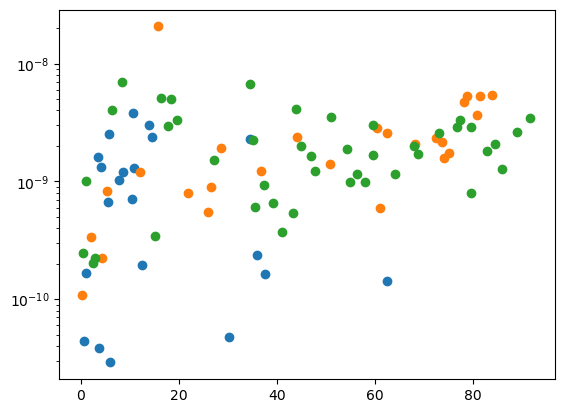

In [25]:
plt.scatter(df.r_z, df.b_z)
plt.scatter(df.r_n, df.b_n)
plt.scatter(df.r_e, df.b_e)

plt.yscale("log")

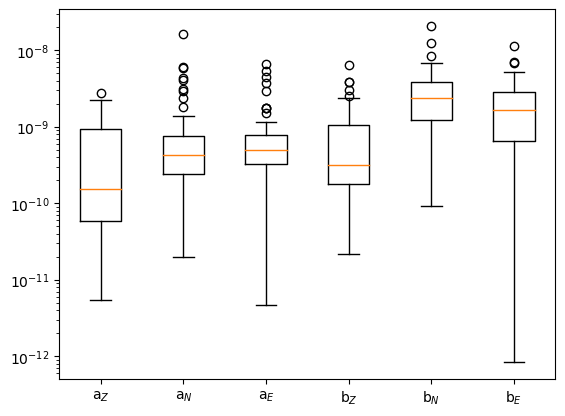

In [58]:
plt.boxplot([abs(df.a_z), abs(df.a_n), abs(df.a_e), abs(df.b_z), abs(df.b_n), abs(df.b_e)],
            labels=[r"a$_Z$", r"a$_N$", r"a$_E$", r"b$_Z$", r"b$_N$", r"b$_E$"])
plt.yscale("log")
plt.show();

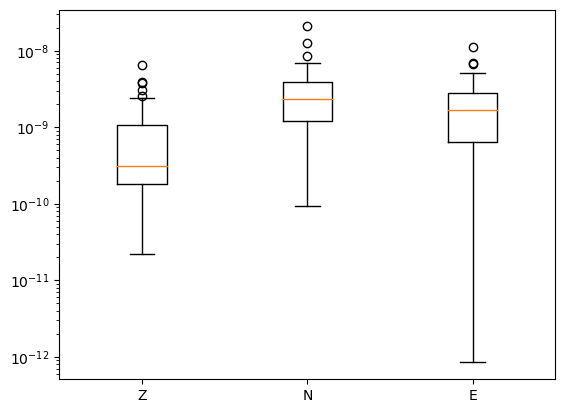

In [50]:
plt.boxplot([abs(df.b_z), abs(df.b_n), abs(df.b_e)], labels=["Z", "N", "E"])
plt.yscale("log")
plt.show();

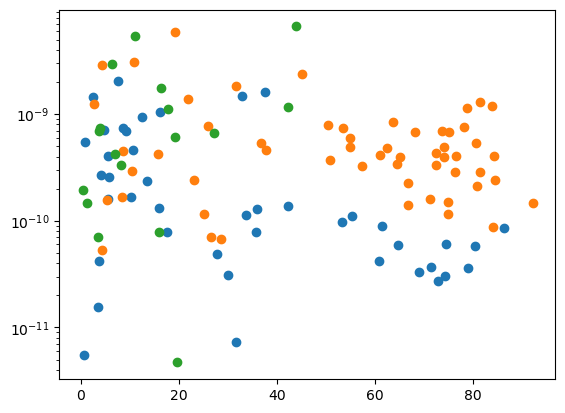

In [26]:
plt.scatter(df.r_z, df.a_z)
plt.scatter(df.r_n, df.a_n)
plt.scatter(df.r_e, df.a_e)

plt.yscale("log")

(0.0, 100.0)

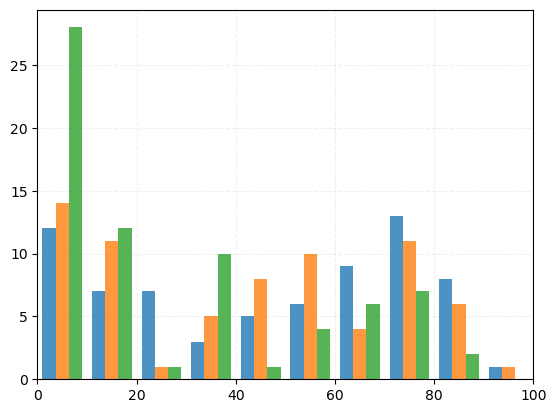

In [33]:
plt.hist([df.r_n, df.r_e, df.r_z], bins=10, range=[0, 100], alpha=0.8, rwidth=0.8, align="mid", density=False, zorder=2)
plt.grid(alpha=0.2, ls="--", zorder=0)
plt.xlim(0, 100)

(-2000.0, 2000.0)

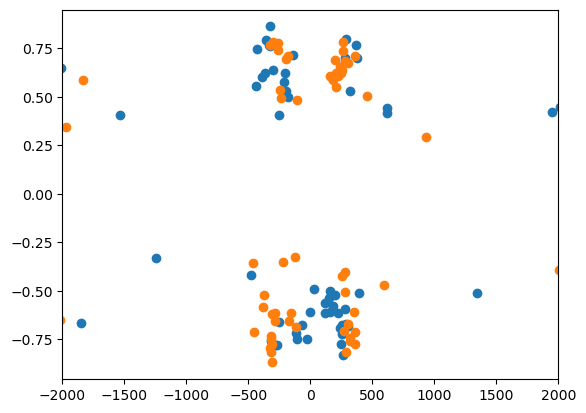

In [34]:
plt.scatter(df.shift_PP_E, df.cmax_PP_E)
plt.scatter(df.shift_PP_N, df.cmax_PP_N)

plt.xlim(-2000, 2000)

(-2000.0, 2000.0)

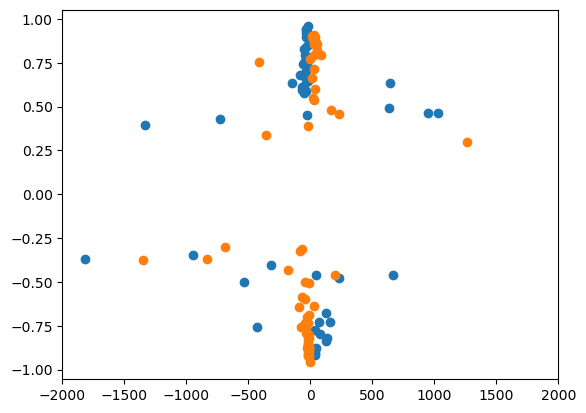

In [35]:
plt.scatter(df.shift_HP_E, df.cmax_HP_E)
plt.scatter(df.shift_HP_N, df.cmax_HP_N)

plt.xlim(-2000, 2000)

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

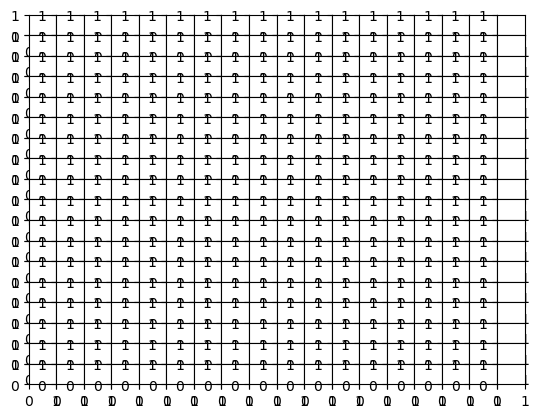

In [30]:
import pandas as pd

df2 = df.copy()
df2 = df2.loc[:, df2.columns != "t1"]
df2 = df2.loc[:, df2.columns != "t2"]
df2 = df2.loc[:, df2.columns != "status"]

df2

pd.plotting.scatter_matrix(df, alpha=0.2)